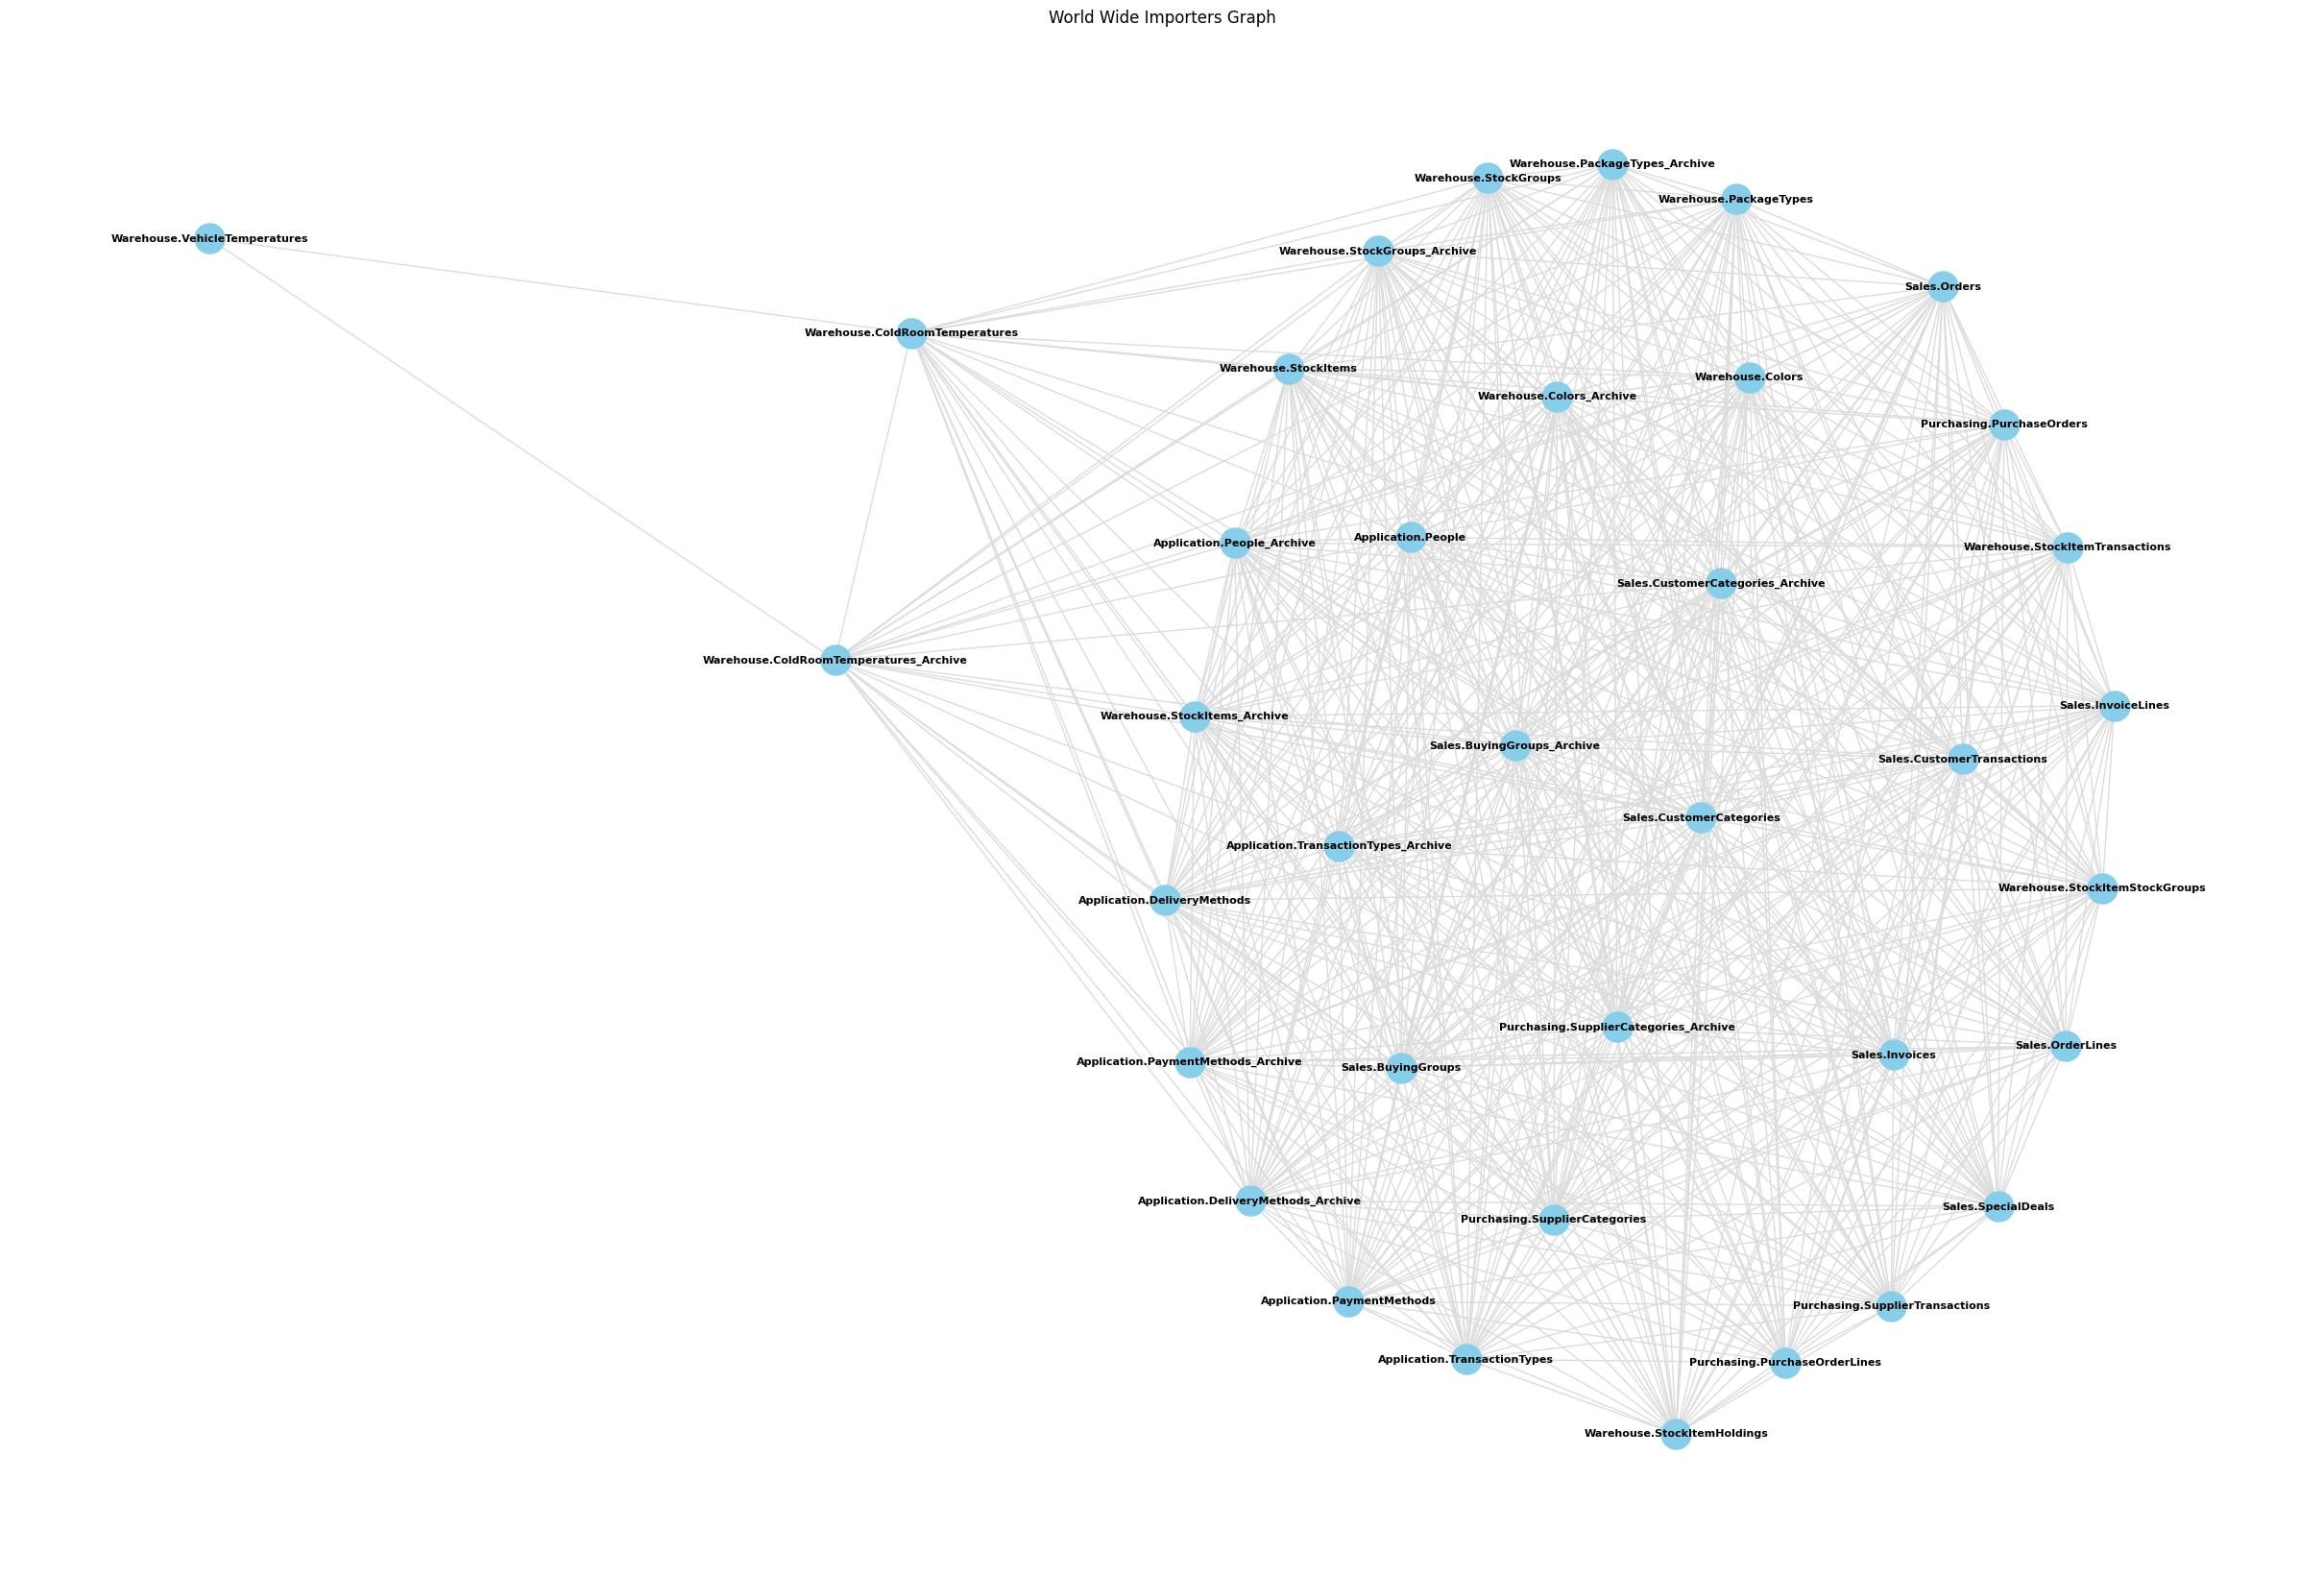

In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt

# Load the graph
with open(r'C:\Python\Python\AAA_UNI\MBD\Project\gitlab\graph_analysis\wwi_graph_degree_org.pickle', 'rb') as f:
    G = pickle.load(f)

# Define the layout positions
pos = nx.kamada_kawai_layout(G)

# Identify isolated nodes
isolated_nodes = list(nx.isolates(G))

# Plot the graph
plt.figure(figsize=(24, 16))
nx.draw(G, pos, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold')
nx.draw_networkx_nodes(G, pos, nodelist=isolated_nodes, node_color='red', node_size=500)
plt.title("World Wide Importers Graph")
plt.show()

In [2]:
# Compute density
density = nx.density(G)
print(f"Density of Graph: {density:.4f}")

# Compute clustering coefficient
clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient of Graph: {clustering:.4f}")

Density of Graph: 0.9129
Average Clustering Coefficient of Graph: 0.9717


In [3]:
import numpy as np
from sklearn.cluster import spectral_clustering

# Function to estimate the number of clusters using spectral clustering
def estimate_clusters_spectral(G, max_clusters=10):
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues, _ = np.linalg.eigh(L)
    eigengap = np.diff(eigenvalues)

    # Identify the largest eigengap
    num_clusters = np.argmax(eigengap[:max_clusters]) + 1
    return num_clusters

# Estimate number of clusters for the graph
num_clusters = estimate_clusters_spectral(G)
print(f"Estimated Number of Clusters in Graph: {num_clusters}")

Estimated Number of Clusters in Graph: 2


c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\tadas\AppData\Local\Temp\ipykernel_5952\1875152360.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_clusters)  # Colormap
c:\Users\tadas\AppData\Local

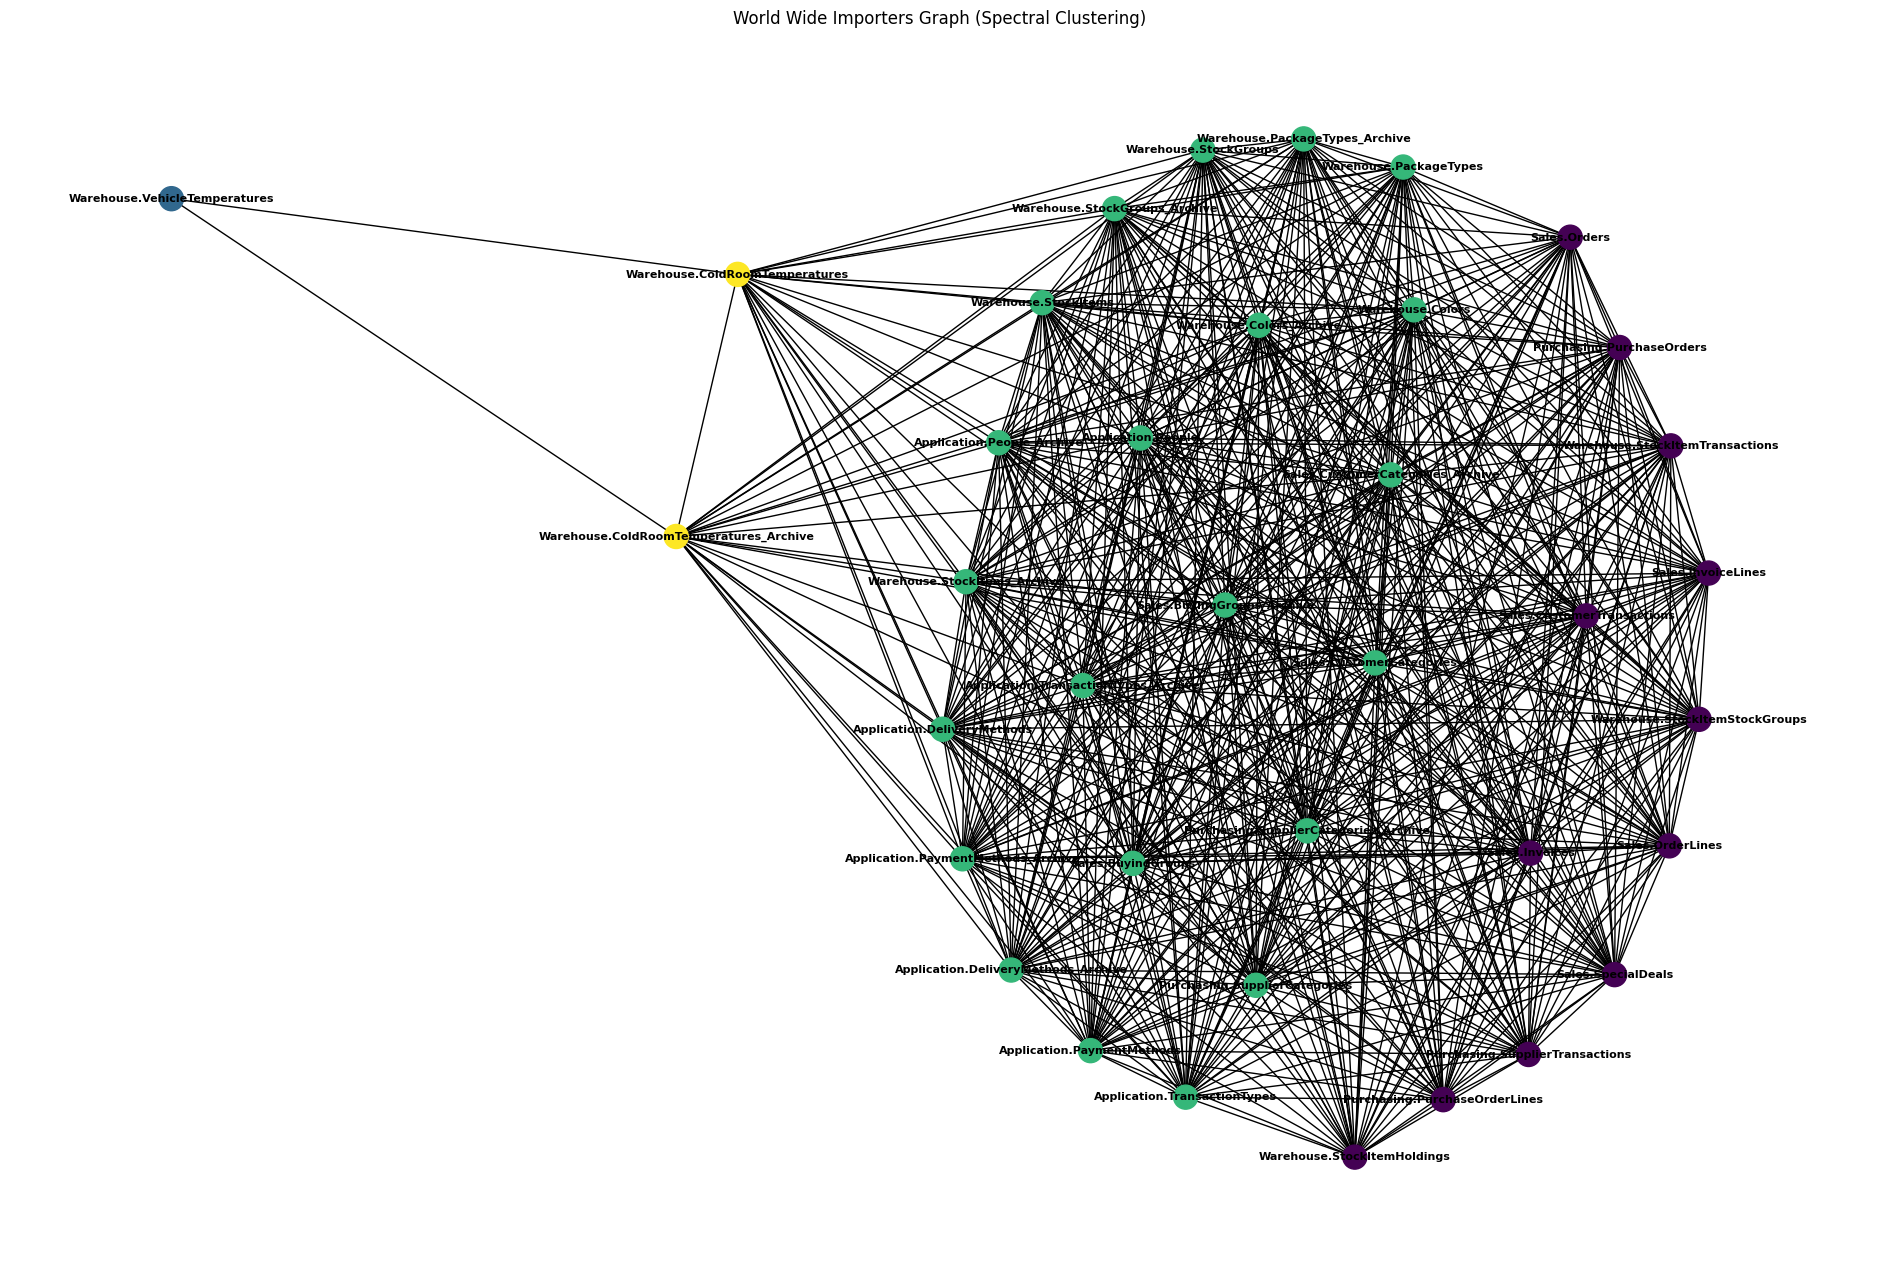

In [4]:
# Function to convert graph to adjacency matrix
def graph_to_adjacency_matrix(G):
    return nx.to_numpy_array(G)

# Function to get node colors based on cluster labels
def get_node_colors(G, cluster_labels):
    num_clusters = len(set(cluster_labels))  # Number of clusters
    cmap = plt.cm.get_cmap('viridis', num_clusters)  # Colormap 
    node_colors = [cmap(label) for label in cluster_labels]
    return node_colors

# Function to perform spectral clustering and plot the graph
def spectral_cluster_and_plot(G, ax, num_clusters):
    A = graph_to_adjacency_matrix(G)
    cluster_labels = spectral_clustering(A, n_clusters=num_clusters)
    node_colors = get_node_colors(G, cluster_labels)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, cmap=plt.cm.viridis, node_size=300, font_size=8, font_weight='bold', ax=ax)
    return cluster_labels, pos, node_colors

# Plot the clustered graph
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("World Wide Importers Graph (Spectral Clustering)")
cluster_labels, pos, node_colors = spectral_cluster_and_plot(G, ax, num_clusters=4)
plt.show()

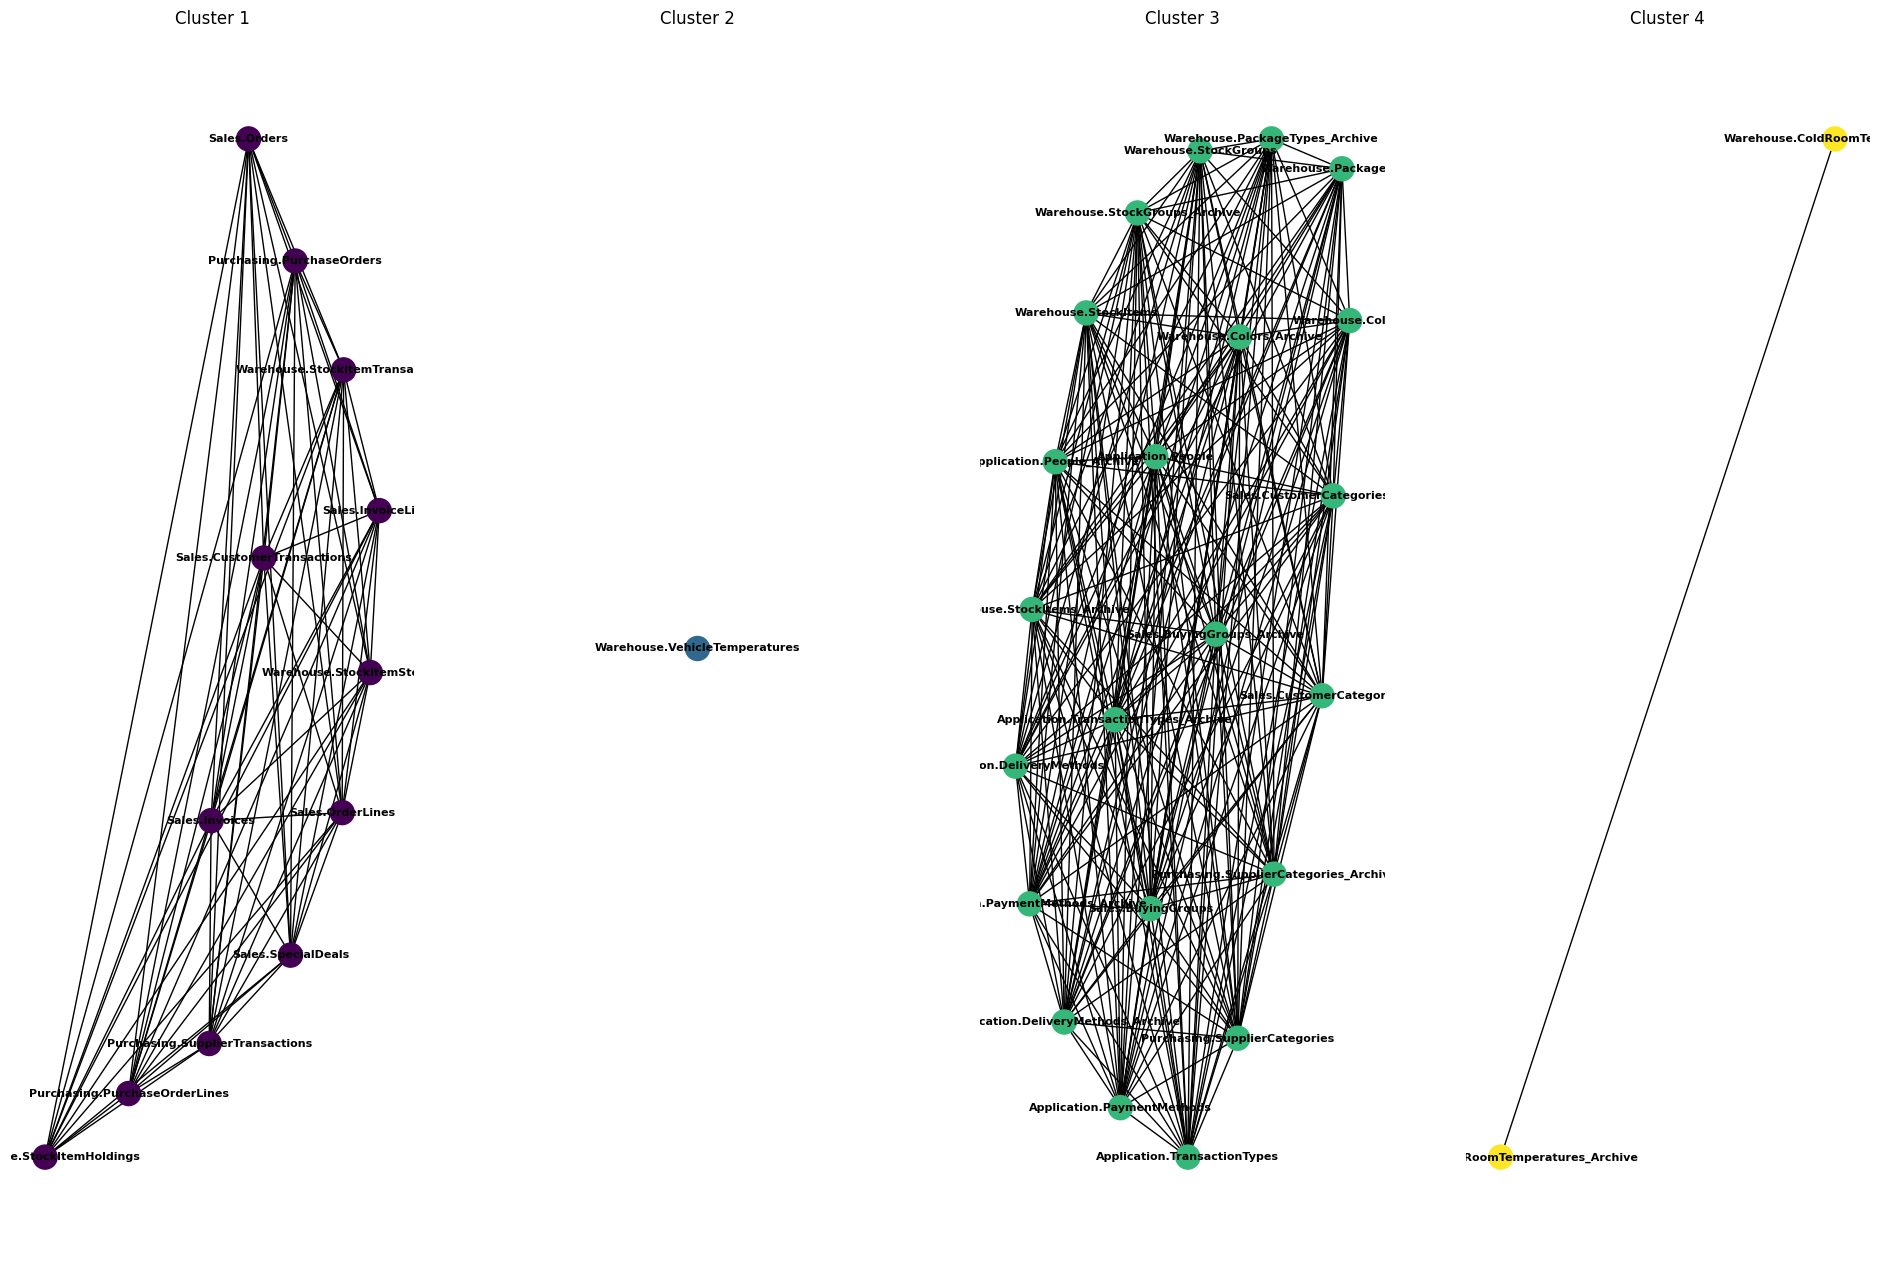

In [5]:
# Function to visualize clusters as separate subgraphs
def visualize_clusters_as_subgraphs(G, cluster_labels, pos, node_colors):
    unique_clusters = set(cluster_labels)
    fig, axs = plt.subplots(1, len(unique_clusters), figsize=(24, 16))
    for cluster, ax in zip(unique_clusters, axs):
        nodes_in_cluster = [node for node, label in zip(G.nodes(), cluster_labels) if label == cluster]
        subgraph = G.subgraph(nodes_in_cluster)
        subgraph_node_colors = [node_colors[list(G.nodes()).index(node)] for node in nodes_in_cluster]
        nx.draw(subgraph, pos=pos, with_labels=True, node_color=subgraph_node_colors, cmap=plt.cm.viridis, node_size=300, font_size=8, font_weight='bold', ax=ax)
        ax.set_title(f"Cluster {cluster + 1}")
    plt.show()

# Visualize clusters as separate subgraphs
visualize_clusters_as_subgraphs(G, cluster_labels, pos, node_colors)

In [6]:
import pandas as pd

# Create dataframes for the clusters
def create_cluster_dataframe(G, cluster_labels):
    data = [{'cluster_label': cluster, 'node_label': node.split('.')[1] if '.' in node else node} for node, cluster in zip(G.nodes(), cluster_labels)]
    df = pd.DataFrame(data)
    return df

df_clusters = create_cluster_dataframe(G, cluster_labels)

In [7]:
# Load the table names DataFrame
table_names_df = pd.read_csv(r"C:\\Python\\Python\\AAA_UNI\\MBD\\Project\\gitlab\\graph_analysis\\tables_and_schemas_wwi.csv")

In [8]:
# Define the similarity calculation function
def calculate_similarity(schema_df, cluster_df):
    schema_set = set(schema_df['table_name'])
    matching = sum(1 for label in cluster_df['node_label'] if label in schema_set)
    total_schema = len(schema_df)
    total_cluster = len(cluster_df)
    return matching, total_schema, total_cluster

In [9]:
# Define the function to calculate best matches
def calculate_best_matches(subgraph_node_data):
    best_matches = {}
    best_similarity = {}
    match_ratio = {}

    unique_clusters = subgraph_node_data['cluster_label'].unique()
    for cluster in unique_clusters:
        cluster_df = subgraph_node_data[subgraph_node_data['cluster_label'] == cluster]
        best_similarity[cluster] = 0.0
        best_matches[cluster] = None

        unique_schemas = table_names_df['table_schema'].unique()

        for schema in unique_schemas:
            schema_df = table_names_df[table_names_df['table_schema'] == schema]
            matching, total_schema, total_cluster = calculate_similarity(schema_df, cluster_df)

            similarity_percentage = (matching / total_cluster) * 100

            if similarity_percentage > best_similarity[cluster]:
                best_similarity[cluster] = similarity_percentage
                best_matches[cluster] = schema

            match_ratio[(cluster, schema)] = f"{total_cluster}/{matching}"

    overall_average_similarity = 0
    for cluster, schema in best_matches.items():
        if schema is not None:
            print(f"Best match for cluster {cluster+1} is schema '{schema}' with similarity {best_similarity[cluster]:.2f}% ({match_ratio[(cluster, schema)]})")
            overall_average_similarity += best_similarity[cluster]
    print(f'Overall Average similarity: {(overall_average_similarity/len(best_matches.items())):.2f}%')

In [10]:
# Apply the similarity calculation to the clustered graph
print("World Wide Importers Graph Clustering:")
calculate_best_matches(df_clusters)

World Wide Importers Graph Clustering:
Best match for cluster 3 is schema 'Warehouse' with similarity 36.36% (22/8)
Best match for cluster 1 is schema 'Sales' with similarity 50.00% (12/6)
Best match for cluster 4 is schema 'Warehouse' with similarity 100.00% (2/2)
Best match for cluster 2 is schema 'Warehouse' with similarity 100.00% (1/1)
Overall Average similarity: 71.59%
